# Resting state notebook

This is a notebook designed to try and extract the correlation matrix of timeseries

Things to be aware of:
NiftiLabelsMasker automatically removes 'background' label from havard-oxford manual

Proceedure
1) extract time series from denoised image
2) Concat cortical and sub-cortical time series together
3) Build covariance matrix out of them
4) Grop difference stuff


In [1]:
from decouple import config
import os
import glob
import pandas as pd
from nilearn import datasets, plotting, image 
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds_strategy
import numpy as np

In [2]:
resting_path: str = os.path.join(config('resting'), 'preprocessed')
fmri_imgs = glob.glob(f'{resting_path}/*/func/*_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
dataset_cortical = datasets.fetch_atlas_harvard_oxford("cortl-maxprob-thr25-2mm")
cortical_atlas_filename = dataset_cortical.maps
cortical_labels = dataset_cortical.labels
sub_cortical_atlas = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm")
subcortical_atlas_filename = sub_cortical_atlas.maps
subcortical_labels = sub_cortical_atlas.labels

In [4]:
confounds  = load_confounds_strategy(fmri_imgs[0], denoise_strategy='compcor', motion='full')[0]
confounds = confounds.drop(list(confounds.filter(regex='cosine*')), axis=1)

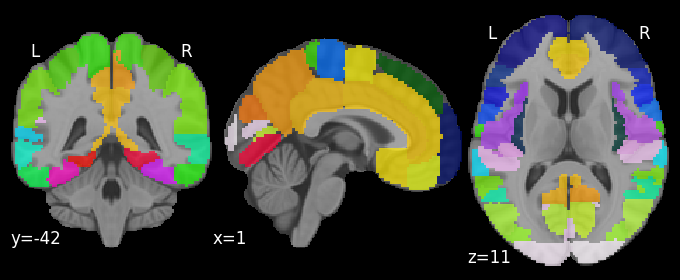

In [52]:
plotting.plot_roi(cortical_atlas_filename, black_bg='on', draw_cross=False)

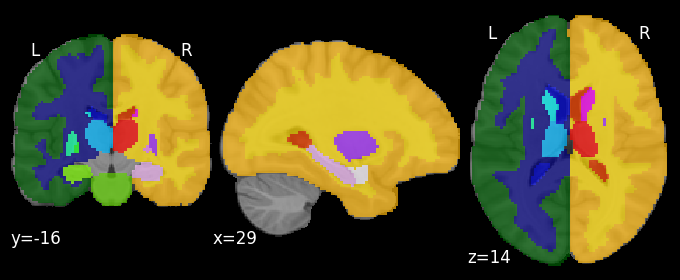

In [53]:
plotting.plot_roi(subcortical_atlas_filename, black_bg='on', draw_cross=False)

In [54]:
cortical_masker = NiftiLabelsMasker(labels_img=cortical_atlas_filename, 
                           labels=cortical_labels,
                           standardize="zscore",
                           standardize_confounds="zscore",
                           memory="nilearn_cache",
                           verbose=5)
subcortical_masker = NiftiLabelsMasker(labels_img=subcortical_atlas_filename, 
                           labels=subcortical_labels,
                           standardize="zscore",
                           standardize_confounds="zscore",
                           memory="nilearn_cache",
                           verbose=5)

In [55]:
fmri_clean = image.clean_img(fmri_imgs[0], low_pass=0.1, high_pass=0.01, t_r=2, ensure_finite=True, confounds=confounds)
cortical_time_series = cortical_masker.fit_transform(fmri_clean)
subcortical_time_series = subcortical_masker.fit_transform(fmri_clean)

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3.8s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f4952694e20>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f494fb79de0>, 
{ 'background_label': 0,
  'detrend': Fals

/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/nilearn/maskers/nifti_labels_masker.py:617: UserWarning: Persisting input arguments took 3.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(


In [68]:
subcortical_time_series_df.columns

Index(['Left Cerebral White Matter', 'Left Cerebral Cortex ',
       'Left Lateral Ventrical', 'Left Thalamus', 'Left Caudate',
       'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus',
       'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter',
       'Right Cerebral Cortex ', 'Right Lateral Ventricle', 'Right Thalamus',
       'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus',
       'Right Amygdala', 'Right Accumbens'],
      dtype='object')

In [69]:
subcortical_time_series_df = pd.DataFrame(subcortical_time_series, columns=subcortical_labels[1:]).drop(columns=['Left Cerebral White Matter', 'Left Cerebral Cortex ',
       'Left Lateral Ventrical', 'Right Cerebral White Matter',
       'Right Cerebral Cortex ', 'Right Lateral Ventricle'])


In [73]:
cortical_time_series_df = pd.DataFrame(cortical_time_series, columns=cortical_labels[1:])
time_series_df = pd.concat((cortical_time_series_df, subcortical_time_series_df), axis=1)

In [81]:
times_series_labels = cortical_time_series_df.columns.to_list() +  subcortical_time_series_df.columns.to_list()

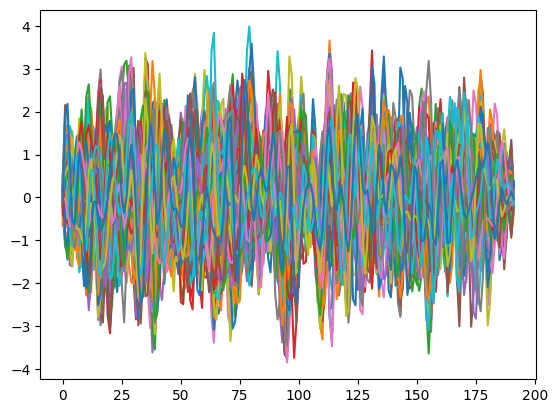

In [76]:
import matplotlib.pyplot as plt

plt.plot(time_series_df)
plt.show()

In [78]:
correlation_measure = ConnectivityMeasure(kind="correlation")
correlation_matrix = correlation_measure.fit_transform([time_series_df.values])[0]

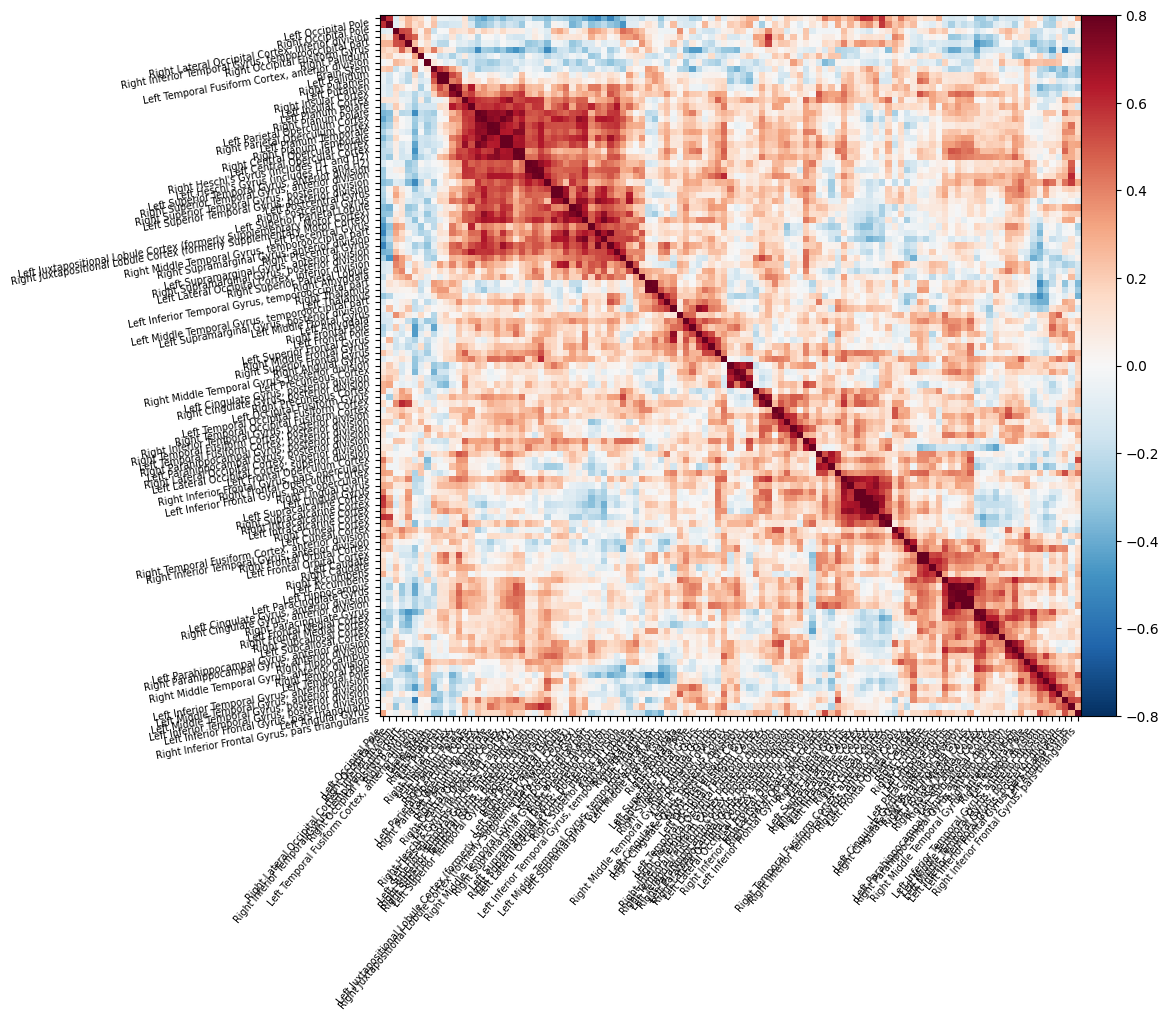

In [82]:
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=times_series_labels,
    vmax=0.8,
    vmin=-0.8,
    reorder=True,
)